# Import Packages

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import utils
from sklearn.metrics import mean_squared_error
import numpy as np
from isoweek import Week
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Settings

In [2]:
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'

forecast_horizon = 1

n_splits = 4

target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Sales Data

In [ ]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

In [ ]:
df = df_raw.copy()
df

# Data Preprocessing

In [ ]:
# keep only relevant columns
df = df[['Week', 'Year', 'Site_ID', 'SKU', 'Sales_QTY', 'Turnover','Season_Year',
       'Vendor_ID','Price_Level','Web_Article','CENSHARE_CAT_1', 'CENSHARE_CAT_2', 'CENSHARE_CAT_3']].copy()

In [ ]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Replace Censhare Cat if not applicable
df.loc[df.CENSHARE_CAT_1.isna(), 'CENSHARE_CAT_1'] = 'NA'

In [11]:
df = pd.read_csv('data.csv')

c:\dev\verteiler\venv5\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2','rolling_std_w4','rolling_std_w8'
]

features = cat_features + num_features

In [13]:
# Convert categorical features to integers 
df, encoders_dict = utils.encode_categorical(df, cat_features, return_encoders = True)

# Feature Engineering

In [14]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4).mean())

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8).mean())

df['rolling_std_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4).std())

df['rolling_std_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8).std())

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [15]:
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Price,Season_Year,Vendor_ID,...,rolling_mean_w4,rolling_mean_w8,rolling_std_w4,rolling_std_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
0,0,0,2015W1,0,0,5.0,129.50,25.90,4,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,2015W2,0,0,2.0,51.80,25.90,4,24,...,NaN,NaN,NaN,NaN,129.5,NaN,NaN,NaN,NaN,NaN
2,2,0,2015W3,0,0,0.0,0.00,25.90,4,24,...,NaN,NaN,NaN,NaN,51.8,129.5,NaN,NaN,NaN,NaN
3,3,0,2015W4,0,0,1.0,25.90,25.90,4,24,...,NaN,NaN,NaN,NaN,0.0,51.8,129.5,NaN,NaN,NaN
4,4,0,2015W5,0,0,0.0,0.00,25.90,4,24,...,51.8,NaN,55.950395,NaN,25.9,0.0,51.8,129.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821434,46,5,2020W47,0,9498,4.0,56.09,14.90,4,211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7821435,46,5,2020W47,0,9499,2.0,29.80,14.90,4,211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7821436,46,5,2020W47,0,9500,5.0,32.87,6.57,4,211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7821437,46,5,2020W47,0,9501,4.0,27.60,6.90,4,211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Forecasting

In [16]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=n_splits)

In [17]:
model_params = {
    'seed': 10,
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 2^7,
    'learning_rate': 0.25
    }

In [58]:
rmse = []
rmse_per_class = {"A": [], "B": [], "C": []}

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][features]
    y_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][target_variable]

    x_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][features]
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    for classification in ['A','B','C']:
        df_class = x_test.copy()
        df_class['Prediction'] = y_pred
        df_class[target_variable] = y_test
        df_class = df_class.merge(df[['Site_ID', 'SKU','Classification']].drop_duplicates(), on=['Site_ID', 'SKU'])
        df_class = df_class.loc[df_class.Classification == classification]
        rmse_per_class[classification].append(
            mean_squared_error(df_class.Prediction, df_class[target_variable], squared=False))

    
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))

    clear_output()

In [59]:
print('RMSE:\n', rmse) 
print('\nCrossvalidated RMSE: ', np.mean(rmse))


# Print results
print('Per Class RMSE RMSE:\n', rmse_per_class)

RMSE:
 [101.45641938588844, 68.53024309336509, 63.14953044067182, 69.30858610383727]

Crossvalidated RMSE:  75.61119475594066
Per Class RMSE RMSE:
 {'A': [77.2549776403981, 71.28307576381145, 62.957294479432406, 78.2628195693562], 'B': [70.27936471991524, 62.06784025366548, 61.036253305754705, 69.38850099232103], 'C': [120.5480760416837, 72.08990950285606, 64.58233718235898, 67.56346852797762]}


****** 5W45 ******


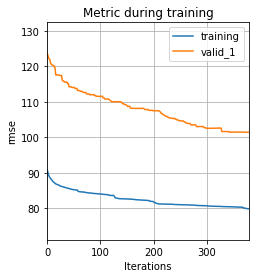

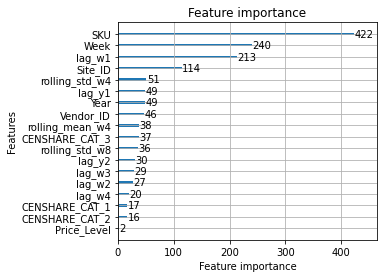

In [90]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals,figsize=(4,4))
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig('fig1.pdf')
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(6,4))
    plt.gcf().subplots_adjust(left=0.3)
    plt.savefig('fig2.pdf')
    plt.show()
    
    break